# Analysis of Spaceship Titanic dataset

We have binary dataset of simulated data. The idea behind the data is transportation of the passangers from the planet Earth to another. Let's see how the data looks like. 

### In this iteration we drop missing values from the training set and will not create Spend column and keep all columns from the shopping. Plus we try to scale continuous values to extract outliers from the data (Scaling data did not help to improve). We still can modify age as most important feature in the data

In [179]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,\
ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler

import pickle

In [180]:
df_train = pd.read_csv("train.csv")
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [181]:
df_test = pd.read_csv("test.csv")
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [182]:
print(df_train.isna().sum())
df_test.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

We have around 200 observation with missing values in training dataset and 100 observations in test dataset. Since we have to upload prediction for all passengers drop missing values is not the right case and we will try to generate this values for proper analysis

In [183]:
df_train = df_train.dropna(axis=0)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   6606 non-null   object 
 1   HomePlanet    6606 non-null   object 
 2   CryoSleep     6606 non-null   object 
 3   Cabin         6606 non-null   object 
 4   Destination   6606 non-null   object 
 5   Age           6606 non-null   float64
 6   VIP           6606 non-null   object 
 7   RoomService   6606 non-null   float64
 8   FoodCourt     6606 non-null   float64
 9   ShoppingMall  6606 non-null   float64
 10  Spa           6606 non-null   float64
 11  VRDeck        6606 non-null   float64
 12  Name          6606 non-null   object 
 13  Transported   6606 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 729.0+ KB


In [184]:
df_full = pd.concat([df_train, df_test], axis=0)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10883 entries, 0 to 4276
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   10883 non-null  object 
 1   HomePlanet    10796 non-null  object 
 2   CryoSleep     10790 non-null  object 
 3   Cabin         10783 non-null  object 
 4   Destination   10791 non-null  object 
 5   Age           10792 non-null  float64
 6   VIP           10790 non-null  object 
 7   RoomService   10801 non-null  float64
 8   FoodCourt     10777 non-null  float64
 9   ShoppingMall  10785 non-null  float64
 10  Spa           10782 non-null  float64
 11  VRDeck        10803 non-null  float64
 12  Name          10789 non-null  object 
 13  Transported   6606 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.2+ MB


In [185]:
df_full.iloc[6604:6608, :]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False
8692,9280_02,Europa,False,E/608/S,TRAPPIST-1e,44.0,False,126.0,4688.0,0.0,0.0,12.0,Propsh Hontichre,True
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,NaN
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,NaN


### We start from analysis of each column and replace missing values

#### Since we will not consider Passenger ID for model simulation which could introduce bias, first column will be Home Planet

In [186]:
df_full["HomePlanet"].value_counts()

Earth     5829
Europa    2675
Mars      2292
Name: HomePlanet, dtype: int64

In [187]:
df_full["HomePlanet"].isna().sum()

87

I lean towards replacements all values with Earth, since majority of the passengers ~60% is from Earth, so on avarage we will be right in 60 % observations. So for 170 observation we have a good data and rest 100 will not have large impact on data compare to 12K observations

In [188]:
df_full.loc[df_full["HomePlanet"].isna(), "HomePlanet"] = "Earth"
df_full["HomePlanet"].value_counts()

Earth     5916
Europa    2675
Mars      2292
Name: HomePlanet, dtype: int64

### For the second column we examine CryoSleep as False and True value and later convert it to 1 and 0 values

In [189]:
df_full["CryoSleep"].value_counts()

False    6914
True     3876
Name: CryoSleep, dtype: int64

In [190]:
df_full["CryoSleep"].isna().sum()

93

In this case we replace missing data with False as for 65% of the data it will be right approach and for rest 140 missrepresented value will not probably have large imapact 

In [191]:
df_full.loc[df_full["CryoSleep"].isna(), "CryoSleep"] = False
df_full["CryoSleep"] = df_full["CryoSleep"].astype(int)
df_full["CryoSleep"].value_counts()

0    7007
1    3876
Name: CryoSleep, dtype: int64

### Column Cabin as itself does not provide much of the information, so we separate this into columns Deck and Side. 

Number of the room is not well understood since have many 0's and 1's which can be misrepresented by model. So we create new columns and drop Cabin. Later we examine each of newly created 

In [192]:
df_full.loc[df_full["Cabin"].isna(), "Cabin"] = "F/JD/S"

In [193]:
df_full["Deck"] = df_full["Cabin"].apply(lambda x: str(x).split("/")[0])
df_full["Deck"].value_counts()

F    3697
G    3195
E    1130
B     990
C     942
D     616
A     305
T       8
Name: Deck, dtype: int64

In [194]:
def find_value(row):
    try:
        return str(row).split("/")[2]
    except IndexError:
        return None

df_full["Side"] = df_full["Cabin"].apply(find_value)    
df_full["Side"].value_counts()

S    5538
P    5345
Name: Side, dtype: int64

In [195]:
df_full["Side"].isna().sum()

0

I replaced Deck with F value and Side with S as most common and for majority will be correct. Another approach would be just drop values in training set and replace values in test.

In [196]:
df_full = df_full.drop(columns="Cabin", axis=1)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side
0,0001_01,Europa,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P
1,0002_01,Earth,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S
2,0003_01,Europa,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S
3,0003_02,Europa,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S
4,0004_01,Earth,0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S


#### Next column will be Destination. 

In [197]:
df_full["Destination"].value_counts()

TRAPPIST-1e      7532
55 Cancri e      2248
PSO J318.5-22    1011
Name: Destination, dtype: int64

In [198]:
df_full["Destination"].isna().sum()

92

We have majority who is moving to the planet Trappist and 70% we have a good chance for replacing missing values for this planet. Later we will use dummy variables to trasform this column. 

In [199]:
df_full.loc[df_full["Destination"].isna(), "Destination"] = "TRAPPIST-1e"
df_full["Destination"].value_counts()

TRAPPIST-1e      7624
55 Cancri e      2248
PSO J318.5-22    1011
Name: Destination, dtype: int64

In [200]:
df_full["Destination"] = df_full["Destination"].replace("TRAPPIST-1e", "TRAPPIST").replace("55 Cancri e", "Cancri").replace("PSO J318.5-22", "PSO")
df_full["Destination"].value_counts()

TRAPPIST    7624
Cancri      2248
PSO         1011
Name: Destination, dtype: int64

#### Next column age. For this case we use avarage age for the population.

In [201]:
df_full["Age"].describe()

count    10792.000000
mean        28.802539
std         14.396816
min          0.000000
25%         19.000000
50%         27.000000
75%         38.000000
max         79.000000
Name: Age, dtype: float64

In [202]:
df_full["Age"].isna().sum()

91

In [203]:
df_full.loc[df_full["Age"].isna(), "Age"] = 28
df_full.describe()

,CryoSleep,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,10883.000000,10883.000000,10801.000000,10777.000000,10785.000000,10782.000000,10803.000000
mean,0.356152,28.795828,221.544764,463.680894,177.945387,309.246151,306.472369
std,0.478883,14.336679,630.484127,1621.887223,570.343750,1133.658617,1175.106100
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37.000000,51.000000,81.000000,31.000000,59.000000,44.000000
max,1.000000,79.000000,11567.000000,29813.000000,12253.000000,22408.000000,22272.000000


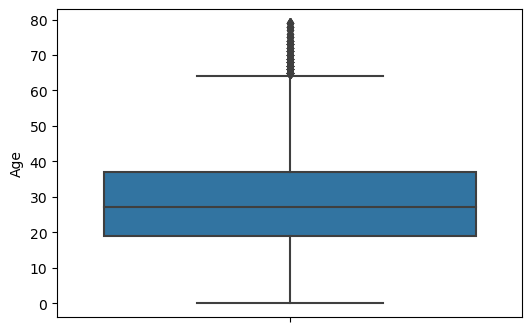

In [204]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["Age"])

plt.ylabel("Age")  

plt.show()

In [205]:
percentile25 = df_full["Age"].quantile(0.25)
percentile75 = df_full["Age"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit", upper_limit)
print("Lower limit", lower_limit)

outlier_age = df_full[(df_full["Age"] > upper_limit) | (df_full["Age"] < lower_limit)]

print("Number of outliers in the Age section", len(outlier_age))
print(1.5 * iqr)

Upper limit 64.0
Lower limit -8.0
Number of outliers in the Age section 137
27.0


We replaced missing values from dataset by average age of the population. Also notible that Age has outliers (237) which could affect some models like Logistic Regression and Naive Bayes. For Random Forest it will affect only in extreme cases, so we stick with this and correct in case of nessacity.

In [206]:
df_full["AgeBucket"] = df_full["Age"] // 15 * 15
df_full["AgeBucket"].value_counts()

15.0    5037
30.0    2944
0.0     1340
45.0    1241
60.0     305
75.0      16
Name: AgeBucket, dtype: int64

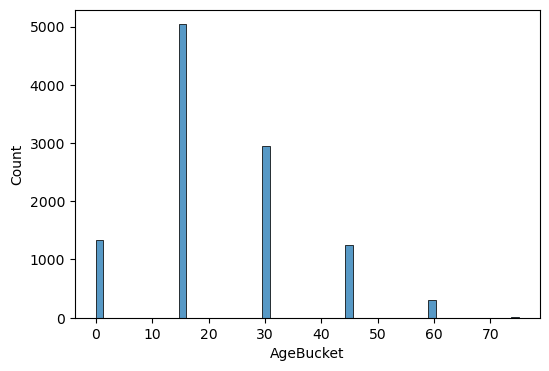

In [207]:
plt.figure(figsize=(6,4))
sns.histplot(df_full["AgeBucket"])
plt.show()

### Next we explore VIP

In [208]:
df_full["VIP"].value_counts()

False    10554
True       236
Name: VIP, dtype: int64

In [209]:
df_full["VIP"].isna().sum()

93

In [210]:
df_full.loc[df_full["VIP"].isna(), "VIP"] = False
df_full["VIP"] = df_full["VIP"].astype(int)
df_full["VIP"].value_counts()

0    10647
1      236
Name: VIP, dtype: int64

In [211]:
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,AgeBucket
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,30.0
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,15.0
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,45.0
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,30.0
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,15.0


### Room Service, Food Court, Shopping Mall, Spa, VR Deck

All these columns have consecutive values and we replace missing values with median value in each column

In [212]:
df_full["RoomService"].describe()

count    10801.000000
mean       221.544764
std        630.484127
min          0.000000
25%          0.000000
50%          0.000000
75%         51.000000
max      11567.000000
Name: RoomService, dtype: float64

In [213]:
df_full["RoomService"].isna().sum()

82

In [214]:
df_full["RoomService"].median()

0.0

In [215]:
df_full.loc[df_full["RoomService"].isna(), "RoomService"] = 0.0
df_full["RoomService"].isna().sum()

0

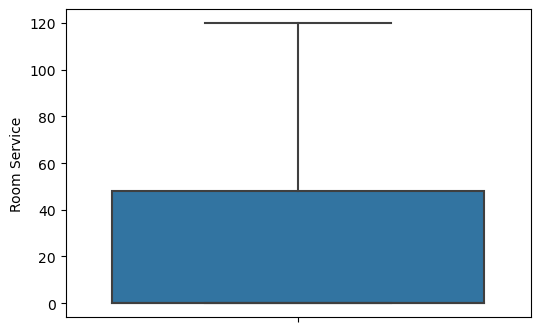

In [216]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["RoomService"], showfliers=False)

plt.ylabel("Room Service")  

plt.show()

As we can see majority of the values are outliers and most probably it is introduce large bias

In [217]:
df_full["FoodCourt"].describe()

count    10777.000000
mean       463.680894
std       1621.887223
min          0.000000
25%          0.000000
50%          0.000000
75%         81.000000
max      29813.000000
Name: FoodCourt, dtype: float64

In [218]:
df_full["FoodCourt"].isna().sum()

106

In [219]:
df_full["FoodCourt"].median()

0.0

In [220]:
df_full.loc[df_full["FoodCourt"].isna(), "FoodCourt"] = 0.0

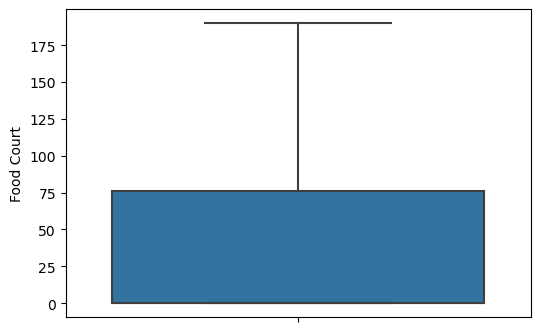

In [221]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["FoodCourt"], showfliers=False)

plt.ylabel("Food Court")  

plt.show()

Similar case for Food Court

In [222]:
df_full["ShoppingMall"].describe()

count    10785.000000
mean       177.945387
std        570.343750
min          0.000000
25%          0.000000
50%          0.000000
75%         31.000000
max      12253.000000
Name: ShoppingMall, dtype: float64

In [223]:
df_full["ShoppingMall"].isna().sum()

98

In [224]:
df_full.loc[df_full["ShoppingMall"].isna(), "ShoppingMall"] = 0.0
df_full["ShoppingMall"].isna().sum()

0

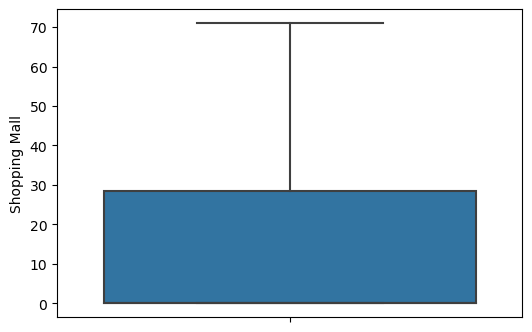

In [225]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["ShoppingMall"], showfliers=False)

plt.ylabel("Shopping Mall")  

plt.show()

In [226]:
df_full["Spa"].describe()

count    10782.000000
mean       309.246151
std       1133.658617
min          0.000000
25%          0.000000
50%          0.000000
75%         59.000000
max      22408.000000
Name: Spa, dtype: float64

In [227]:
df_full["Spa"].isna().sum()

101

In [228]:
df_full.loc[df_full["Spa"].isna(), "Spa"] = 0.0
df_full["Spa"].isna().sum()

0

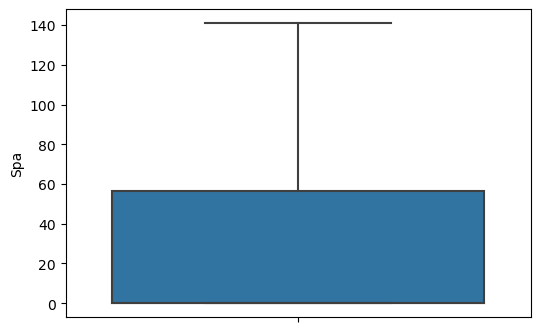

In [229]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["Spa"], showfliers=False)

plt.ylabel("Spa")  

plt.show()

In [230]:
df_full["VRDeck"].describe()

count    10803.000000
mean       306.472369
std       1175.106100
min          0.000000
25%          0.000000
50%          0.000000
75%         44.000000
max      22272.000000
Name: VRDeck, dtype: float64

In [231]:
df_full.loc[df_full["VRDeck"].isna(), "VRDeck"] = 0.0
df_full["VRDeck"].isna().sum()

0

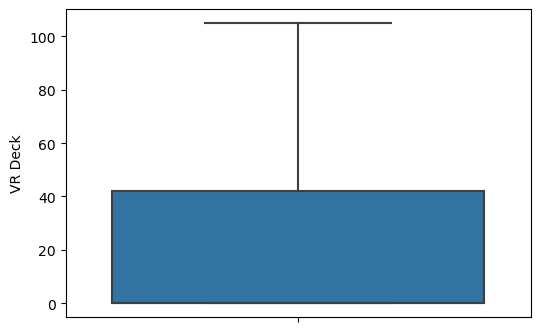

In [232]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["VRDeck"], showfliers=False)

plt.ylabel("VR Deck")  

plt.show()

As we can see every of this column has extensive outliers which can affect our model prediction. We can make one column as TotalSpend

In [233]:
df_full["TotalSpend"] = (
    df_full["RoomService"] + 
    df_full["FoodCourt"] + 
    df_full["ShoppingMall"] + 
    df_full["Spa"] + 
    df_full["VRDeck"]
)
df_full["TotalSpend"].describe()

count    10883.000000
mean      1465.978866
std       2843.459361
min          0.000000
25%          0.000000
50%        724.000000
75%       1467.500000
max      35987.000000
Name: TotalSpend, dtype: float64

In [234]:
df_full["TotalSpend"].isna().sum()

0

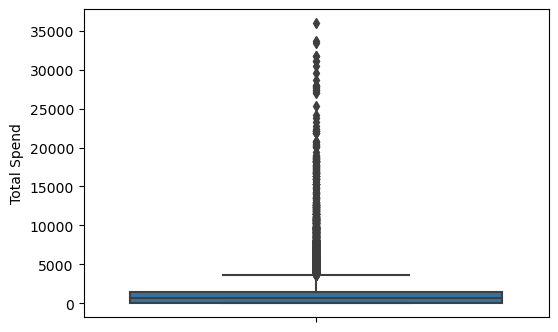

In [235]:
plt.figure(figsize=(6, 4))  
sns.boxplot(y = df_full["TotalSpend"], showfliers=True)

plt.ylabel("Total Spend")  

plt.show()

In [236]:
zeros_TotalSpend = df_full[df_full["TotalSpend"] == 0.0]
print("Number of obs that have 0 spend", len(zeros_TotalSpend))

Number of obs that have 0 spend 4540


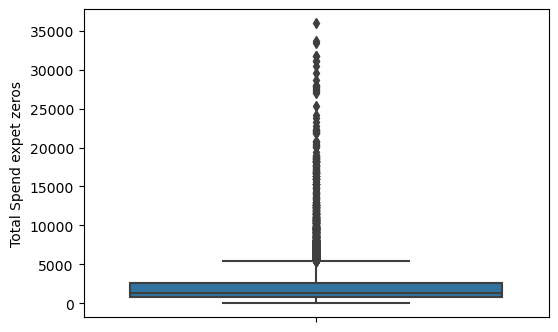

In [237]:
not_zeros = df_full[df_full["TotalSpend"] > 0]
plt.figure(figsize=(6, 4))  
sns.boxplot(y = not_zeros["TotalSpend"], showfliers=True)

plt.ylabel("Total Spend expet zeros")  

plt.show()

##### I have decided to create new column Rich as to describe outliers in this data and rest of the column just drop.

In [238]:
# df_full["Spend"] = df_full["TotalSpend"].apply(lambda x: False if x == 0.0 else True)
# df_full.head()

In [239]:
# df_full["Spend"] = df_full["Spend"].astype(int)
# df_full["Spend"].value_counts()

In [240]:
percentile25 = df_full["TotalSpend"].quantile(0.25)
percentile75 = df_full["TotalSpend"].quantile(0.75)

iqr = percentile75 - percentile25

upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Upper limit", upper_limit)
print("Lower limit", lower_limit)

outlier_total_spend = df_full[(df_full["TotalSpend"] > upper_limit) | (df_full["TotalSpend"] < lower_limit)]

print("Number of outliers in the TotalSpend section", len(outlier_total_spend))

Upper limit 3668.75
Lower limit -2201.25
Number of outliers in the TotalSpend section 1153


We will identify Rich people as someone who spend more 3668 over the trip on accomodation.

In [241]:
df_full["Rich"] = df_full["TotalSpend"].apply(lambda x: True if x >= 3668 else False)
df_full["Rich"] = df_full["Rich"].astype(int)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,AgeBucket,TotalSpend,Rich
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,30.0,0.0,0
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,15.0,736.0,0
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,45.0,10383.0,1
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,30.0,5176.0,1
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,15.0,1091.0,0


Now we can drop columns room service, food court, shopping mall, spa, vr deck and total spend

In [242]:
df_full = df_full.drop(columns=["TotalSpend"], axis=1)
df_full.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,AgeBucket,Rich
0,0001_01,Europa,0,TRAPPIST,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,P,30.0,0
1,0002_01,Earth,0,TRAPPIST,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,S,15.0,0
2,0003_01,Europa,0,TRAPPIST,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,S,45.0,1
3,0003_02,Europa,0,TRAPPIST,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,S,30.0,1
4,0004_01,Earth,0,TRAPPIST,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,S,15.0,0


#### Usualy name does not provide much of useful information, so we drop this column together with passenger id

In [243]:
df_full = df_full.drop(columns=["PassengerId", "Name", "Age"], axis=1)
df_full.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,Side,AgeBucket,Rich
0,Europa,0,TRAPPIST,0,0.0,0.0,0.0,0.0,0.0,False,B,P,30.0,0
1,Earth,0,TRAPPIST,0,109.0,9.0,25.0,549.0,44.0,True,F,S,15.0,0
2,Europa,0,TRAPPIST,1,43.0,3576.0,0.0,6715.0,49.0,False,A,S,45.0,1
3,Europa,0,TRAPPIST,0,0.0,1283.0,371.0,3329.0,193.0,False,A,S,30.0,1
4,Earth,0,TRAPPIST,0,303.0,70.0,151.0,565.0,2.0,True,F,S,15.0,0


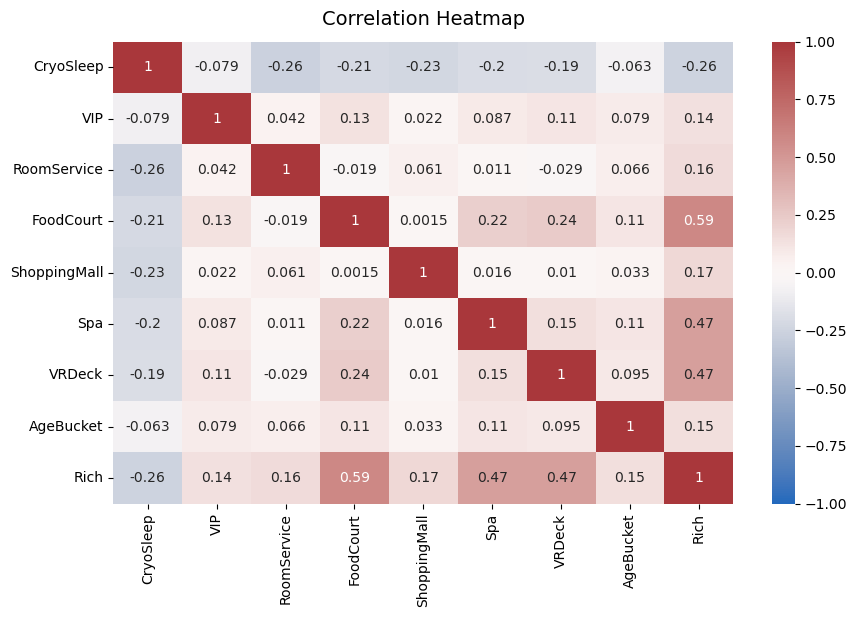

In [244]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_full.corr(), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

#### Now we do not have strong correlation between variables which we expect would help with the model

### Only categorical data left, so we apply dummy encoding to columns Home planet, Destination, Deck and Side

In [245]:
df_full_enc = pd.get_dummies(df_full, columns=["HomePlanet", "Destination", "Deck", "Side", "AgeBucket"], drop_first=False)
df_full_enc.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Rich,HomePlanet_Earth,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
0,0,0,0.0,0.0,0.0,0.0,0.0,False,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,109.0,9.0,25.0,549.0,44.0,True,0,1,...,0,0,0,1,0,1,0,0,0,0
2,0,1,43.0,3576.0,0.0,6715.0,49.0,False,1,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,0.0,1283.0,371.0,3329.0,193.0,False,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,303.0,70.0,151.0,565.0,2.0,True,0,1,...,0,0,0,1,0,1,0,0,0,0


In [246]:
df_full_enc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10883 entries, 0 to 4276
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             10883 non-null  int64  
 1   VIP                   10883 non-null  int64  
 2   RoomService           10883 non-null  float64
 3   FoodCourt             10883 non-null  float64
 4   ShoppingMall          10883 non-null  float64
 5   Spa                   10883 non-null  float64
 6   VRDeck                10883 non-null  float64
 7   Transported           6606 non-null   object 
 8   Rich                  10883 non-null  int64  
 9   HomePlanet_Earth      10883 non-null  uint8  
 10  HomePlanet_Europa     10883 non-null  uint8  
 11  HomePlanet_Mars       10883 non-null  uint8  
 12  Destination_Cancri    10883 non-null  uint8  
 13  Destination_PSO       10883 non-null  uint8  
 14  Destination_TRAPPIST  10883 non-null  uint8  
 15  Deck_A              

Six columns has consecutive values with outstanding outliers which we can eliminate by scaling. Now we apply Standart Scaler to reduce bias in the data

In [247]:
columns_to_scale = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to the selected columns
scaler.fit(df_full_enc[columns_to_scale])

# Transform the selected columns
scaled_columns = scaler.transform(df_full_enc[columns_to_scale])

# Create a copy of the original data and replace the scaled columns with the scaled values
df_full_enc[columns_to_scale] = scaled_columns
df_full_enc.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Rich,HomePlanet_Earth,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
0,0,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,False,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,-0.176450,-0.278820,-0.266452,0.214954,-0.222217,True,0,1,...,0,0,0,1,0,1,0,0,0,0
2,0,1,-0.281484,1.930483,-0.310467,5.677764,-0.217947,False,1,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,-0.349915,0.510261,0.342711,2.677914,-0.094977,False,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0.132286,-0.241038,-0.044619,0.229130,-0.258083,True,0,1,...,0,0,0,1,0,1,0,0,0,0


Now it is time to separate the test data from train data. Also transform the column Transported into binary.

In [248]:
df_full_enc.iloc[6604:6608, :]

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Rich,HomePlanet_Earth,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
8691,0,0,-0.349915,0.365328,-0.310467,0.041307,2.502764,False,1,0,...,0,0,0,1,0,0,1,0,0,0
8692,0,0,-0.149396,2.619225,-0.310467,-0.271436,-0.249543,True,1,0,...,0,0,0,1,0,0,1,0,0,0
0,1,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,NaN,0,1,...,1,0,0,1,0,1,0,0,0,0
1,0,0,-0.349915,-0.278820,-0.310467,2.229620,-0.259791,NaN,0,1,...,0,0,0,1,0,1,0,0,0,0


In [249]:
df_train_corr = df_full_enc.iloc[:6606, :]
df_test_corr = df_full_enc.iloc[6606:, :]
df_test_corr.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Rich,HomePlanet_Earth,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
0,1,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,NaN,0,1,...,1,0,0,1,0,1,0,0,0,0
1,0,0,-0.349915,-0.278820,-0.310467,2.229620,-0.259791,NaN,0,1,...,0,0,0,1,0,1,0,0,0,0
2,1,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,NaN,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,0,-0.349915,3.835673,-0.310467,-0.111078,0.239775,NaN,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,-0.334001,-0.284394,0.807505,-0.271436,-0.259791,NaN,0,1,...,0,0,0,1,0,1,0,0,0,0


In [250]:
df_train_corr.iloc[6602:6607, :]

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Rich,HomePlanet_Earth,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
8689,1,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,False,0,1,...,1,0,0,1,0,1,0,0,0,0
8690,0,0,-0.349915,-0.284394,2.985351,-0.270550,-0.259791,True,0,1,...,1,0,0,1,0,1,0,0,0,0
8691,0,0,-0.349915,0.365328,-0.310467,0.041307,2.502764,False,1,0,...,0,0,0,1,0,0,1,0,0,0
8692,0,0,-0.149396,2.619225,-0.310467,-0.271436,-0.249543,True,1,0,...,0,0,0,1,0,0,1,0,0,0


In [251]:
df_test_corr = df_test_corr.drop(columns=["Transported"], axis=1)
df_test_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4277 entries, 0 to 4276
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             4277 non-null   int64  
 1   VIP                   4277 non-null   int64  
 2   RoomService           4277 non-null   float64
 3   FoodCourt             4277 non-null   float64
 4   ShoppingMall          4277 non-null   float64
 5   Spa                   4277 non-null   float64
 6   VRDeck                4277 non-null   float64
 7   Rich                  4277 non-null   int64  
 8   HomePlanet_Earth      4277 non-null   uint8  
 9   HomePlanet_Europa     4277 non-null   uint8  
 10  HomePlanet_Mars       4277 non-null   uint8  
 11  Destination_Cancri    4277 non-null   uint8  
 12  Destination_PSO       4277 non-null   uint8  
 13  Destination_TRAPPIST  4277 non-null   uint8  
 14  Deck_A                4277 non-null   uint8  
 15  Deck_B               

In [252]:
df_train_corr["Transported"] = df_train_corr["Transported"].astype(int)
df_train_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6606 entries, 0 to 8692
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             6606 non-null   int64  
 1   VIP                   6606 non-null   int64  
 2   RoomService           6606 non-null   float64
 3   FoodCourt             6606 non-null   float64
 4   ShoppingMall          6606 non-null   float64
 5   Spa                   6606 non-null   float64
 6   VRDeck                6606 non-null   float64
 7   Transported           6606 non-null   int64  
 8   Rich                  6606 non-null   int64  
 9   HomePlanet_Earth      6606 non-null   uint8  
 10  HomePlanet_Europa     6606 non-null   uint8  
 11  HomePlanet_Mars       6606 non-null   uint8  
 12  Destination_Cancri    6606 non-null   uint8  
 13  Destination_PSO       6606 non-null   uint8  
 14  Destination_TRAPPIST  6606 non-null   uint8  
 15  Deck_A               

/var/folders/7m/1c5q60f97cx1t7r9pnhv002c0000gn/T/ipykernel_1963/2224148587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_corr["Transported"] = df_train_corr["Transported"].astype(int)


In [253]:
df_train_corr.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Rich,HomePlanet_Earth,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
0,0,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,-0.176450,-0.278820,-0.266452,0.214954,-0.222217,1,0,1,...,0,0,0,1,0,1,0,0,0,0
2,0,1,-0.281484,1.930483,-0.310467,5.677764,-0.217947,0,1,0,...,0,0,0,1,0,0,0,1,0,0
3,0,0,-0.349915,0.510261,0.342711,2.677914,-0.094977,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0.132286,-0.241038,-0.044619,0.229130,-0.258083,1,0,1,...,0,0,0,1,0,1,0,0,0,0


# Constuct phase 

In [254]:
X = df_train_corr.drop(columns=["Transported"], axis=1)
y = df_train_corr["Transported"]
X.head()

,CryoSleep,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Rich,HomePlanet_Earth,HomePlanet_Europa,...,Deck_G,Deck_T,Side_P,Side_S,AgeBucket_0.0,AgeBucket_15.0,AgeBucket_30.0,AgeBucket_45.0,AgeBucket_60.0,AgeBucket_75.0
0,0,0,-0.349915,-0.284394,-0.310467,-0.271436,-0.259791,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1,0,0,-0.176450,-0.278820,-0.266452,0.214954,-0.222217,0,1,0,...,0,0,0,1,0,1,0,0,0,0
2,0,1,-0.281484,1.930483,-0.310467,5.677764,-0.217947,1,0,1,...,0,0,0,1,0,0,0,1,0,0
3,0,0,-0.349915,0.510261,0.342711,2.677914,-0.094977,1,0,1,...,0,0,0,1,0,0,1,0,0,0
4,0,0,0.132286,-0.241038,-0.044619,0.229130,-0.258083,0,1,0,...,0,0,0,1,0,1,0,0,0,0


In [255]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1322 entries, 8441 to 875
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CryoSleep             1322 non-null   int64  
 1   VIP                   1322 non-null   int64  
 2   RoomService           1322 non-null   float64
 3   FoodCourt             1322 non-null   float64
 4   ShoppingMall          1322 non-null   float64
 5   Spa                   1322 non-null   float64
 6   VRDeck                1322 non-null   float64
 7   Rich                  1322 non-null   int64  
 8   HomePlanet_Earth      1322 non-null   uint8  
 9   HomePlanet_Europa     1322 non-null   uint8  
 10  HomePlanet_Mars       1322 non-null   uint8  
 11  Destination_Cancri    1322 non-null   uint8  
 12  Destination_PSO       1322 non-null   uint8  
 13  Destination_TRAPPIST  1322 non-null   uint8  
 14  Deck_A                1322 non-null   uint8  
 15  Deck_B             

### First we try to use Logistic Classifier for the analysis

In [256]:
clf_log = LogisticRegression(random_state=42, max_iter=1500)

In [257]:
%%time
clf_log.fit(X_train, y_train)

CPU times: user 247 ms, sys: 60.6 ms, total: 307 ms
Wall time: 46.8 ms


LogisticRegression(max_iter=1500, random_state=42)

In [258]:
y_pred_log = clf_log.predict(X_val)

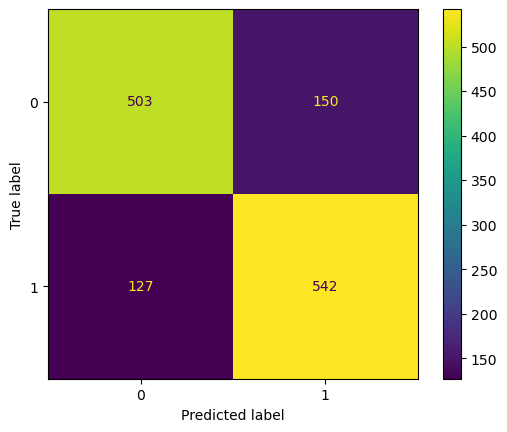

In [259]:
def plot_matrix(model, y_test, y_pred):
    log_cm = confusion_matrix(y_test, y_pred, labels=model.classes_)

    # Create display of confusion matrix
    log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=model.classes_)

    # Plot confusion matrix
    log_disp.plot()

    # Display plot
    plt.show()
    
plot_matrix(clf_log, y_val, y_pred_log)

In [260]:
preds = clf_log.predict(X_val)

auc = round(roc_auc_score(y_val, preds), 3)
accuracy = round(accuracy_score(y_val, preds), 3)
precision = round(precision_score(y_val, preds), 3)
recall = round(recall_score(y_val, preds), 3)
f1 = round(f1_score(y_val, preds), 3)

log_reg_table = pd.DataFrame({'model': "Logistic regression",
                    'AUC': [auc],
                    'precision': [precision], 
                    'recall': [recall],
                    'f1': [f1],
                    'accuracy': [accuracy]
                    })
log_reg_table  

,model,AUC,precision,recall,f1,accuracy
0,Logistic regression,0.79,0.783,0.81,0.796,0.79


This model present not bad results but let's try other options such as Random Forest

### Random Forest Classifier

In [261]:
clf_rf = RandomForestClassifier(random_state=42)

In [266]:
cv_params = {'max_depth': [3,5, None], 
             'max_features': [9,22,32],
             'max_samples': [0.05, 0.1, 0.3],
             'min_samples_leaf': [3, 5, 7],
             'min_samples_split': [2, 3, 4],
             'n_estimators': [100, 300, 500],
             }  

scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [267]:
def make_results(model_name: str, model_object, metric: str):
    '''
    Arguments:
        model_name (string): What you want the model to be called in the output table.
        model_object: A fit GridSearchCV object.
        metric (string): Precision, recall, f1, accuracy, or auc.
  
    Returns a pandas DataFrame with the F1, recall, precision, accuracy, and AUC scores
    for the model with the best mean 'metric' score across all validation folds.  
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {
        'precision': 'mean_test_precision',
        'recall': 'mean_test_recall',
        'f1': 'mean_test_f1',
        'accuracy': 'mean_test_accuracy'
    }

    # Get all the results from the CV and put them in a DataFrame
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the DataFrame with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and F1 score from that row
    f1 = best_estimator_results['mean_test_f1']
    recall = best_estimator_results['mean_test_recall']
    precision = best_estimator_results['mean_test_precision']
    accuracy = best_estimator_results['mean_test_accuracy']
  
    # Create DataFrame of results
    table = pd.DataFrame({
        'Model': [model_name],
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'Accuracy': accuracy
    })
  
    return table

In [268]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In: 
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = round(roc_auc_score(y_test_data, preds), 3)
    accuracy = round(accuracy_score(y_test_data, preds), 3)
    precision = round(precision_score(y_test_data, preds), 3)
    recall = round(recall_score(y_test_data, preds), 3)
    f1 = round(f1_score(y_test_data, preds), 3)

    table = pd.DataFrame({'model': [model_name],
                        'AUC': [auc],
                        'precision': [precision], 
                        'recall': [recall],
                        'f1': [f1],
                        'accuracy': [accuracy]
                        })
  
    return table

In [ ]:
%%time
rf_cv_acc = GridSearchCV(clf_rf, cv_params, scoring=scoring, cv=5, refit='accuracy')
rf_cv_acc.fit(X_train, y_train)

In [91]:
rf_cv_acc.best_score_

0.803934986095582

In [92]:
rf_cv_acc.best_params_

{'max_depth': None,
 'max_features': 22,
 'max_samples': 0.3,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 300}

In [93]:
rf_table_acc = make_results("Random Forest Classifier accuracy", rf_cv_acc, "accuracy")
rf_table_acc

,Model,Precision,Recall,F1,Accuracy
0,Random Forest Classifier accuracy,0.814004,0.791198,0.802412,0.803935


In [94]:
rf_score_acc = get_scores("Random Forest Classifier accuracy", rf_cv_acc, X_val, y_val)
rf_score_acc

,model,AUC,precision,recall,f1,accuracy
0,Random Forest Classifier accuracy,0.822,0.829,0.816,0.822,0.821


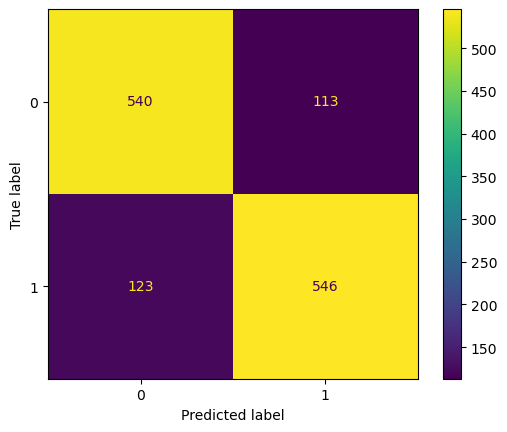

In [95]:
plot_matrix(rf_cv_acc.best_estimator_, y_val, rf_cv_acc.best_estimator_.predict(X_val))

## XGBoost Classifier 

In [96]:
clf_xgb = XGBClassifier(objective="binary:logistic", random_state=42)

cv_params = {
    "max_depth": [3, 6, 9, 12],
    "min_child_weight": [3, 5, 7, 9],
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [100, 300, 500]
}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

xgb_cv = GridSearchCV(clf_xgb, cv_params, scoring=scoring, cv=5, refit="accuracy")

In [97]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 53min 11s, sys: 4min 59s, total: 58min 10s
Wall time: 6min 7s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_ca...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1],
                         'max_depth': [3, 6, 9, 12],
                         'min_child_weight': [3, 5, 7, 9],
                         'n_estimators': [100, 300, 500]},
             refit='accuracy',
             scoring={'accuracy', 'recall', 'f1', 'precision'})

In [98]:
xgb_cv.best_score_

0.8071537871620654

In [99]:
xgb_table_acc = make_results("XGBoost Classifier", xgb_cv, "accuracy")
xgb_table_acc

,Model,Precision,Recall,F1,Accuracy
0,XGBoost Classifier,0.809072,0.807753,0.808254,0.807154


In [100]:
xgb_cv.best_params_

{'learning_rate': 0.01,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 500}

In [101]:
xgb_score_acc = get_scores("XGBoost Classifier", xgb_cv, X_val, y_val)
xgb_score_acc

,model,AUC,precision,recall,f1,accuracy
0,XGBoost Classifier,0.818,0.817,0.825,0.821,0.818


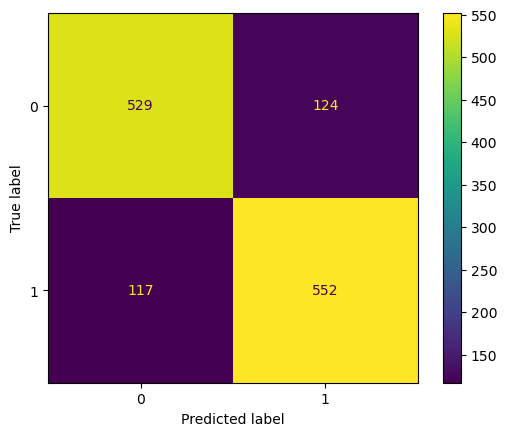

In [102]:
plot_matrix(xgb_cv.best_estimator_, y_val, xgb_cv.best_estimator_.predict(X_val))

In [105]:
table_score = pd.concat([xgb_score_acc, rf_score_acc, log_reg_table])
table_score

,model,AUC,precision,recall,f1,accuracy
0,XGBoost Classifier,0.818,0.817,0.825,0.821,0.818
0,Random Forest Classifier accuracy,0.822,0.829,0.816,0.822,0.821
0,Logistic regression,0.793,0.786,0.813,0.799,0.793


We see that two last model present almost the same result and slightly better than Logistic regression model. Let's look at the feature importance in this prediction

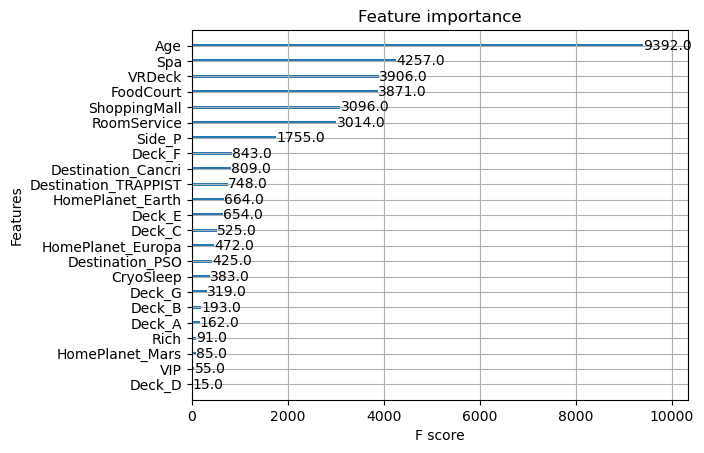

In [106]:
plot_importance(xgb_cv.best_estimator_)
plt.show()

### Considering the values we will stick with Random Forest Classifier

In [197]:
model = rf_cv_acc.best_estimator_

In [198]:
predictions = model.predict(df_test_corr)

In [210]:
output = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Transported': predictions})
output["Transported"] = output["Transported"].astype(bool)
output.to_csv('submission.csv', index=False)

### On the validation set we did get 82.1 accuracy score which was good comapare even to grid serch. Let's see what test data will show us. 

So get best score 0.79144 and place in a queue is 1456. Could be better, so let's look and some improve

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Rich,HomePlanet_Earth,...,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,1,27.0,0,0.0,0.0,0.0,0.0,0.0,0,1,...,0,0,0,0,0,0,1,0,0,1
1,0,19.0,0,0.0,9.0,0.0,2823.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,1,31.0,0,0.0,0.0,0.0,0.0,0.0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,0,38.0,0,0.0,6652.0,0.0,181.0,585.0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,0,20.0,0,10.0,0.0,635.0,0.0,0.0,0,1,...,0,0,0,0,0,1,0,0,0,1


0    2209
1    2068
Name: Transported, dtype: int64

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,1
4,0023_01,1
